# Análise Exploratória dos Dados

## Setup

In [16]:
import numpy as np 
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px
from shutil import copy2

# Matplotlib options
rcParams['figure.figsize'] = (10, 8)
rcParams['axes.grid'] = False
plt.style.use('seaborn-deep')

# Pandas setup
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000) 
pd.set_option('display.max_colwidth', -1) 

In [51]:
# Read file
path = "./Tidy_Entities/"
name = "p1"
filename = name + ".csv"
df = pd.read_csv(path + filename, encoding='utf8')

# Transformations
df["DATE"] =  pd.to_datetime(df["DATE"], format="%Y-%m-%d")
df.drop(columns=["ENTIDADE"], inplace=True)
df.head()

,DATE,ALUMÍNIO,ARSÊNIO,BORO,BÁRIO,CHUMBO,CIANETO,COBALTO,COBRE,COLIFORMES_TERMOTOLERANTES,COR_VERDADEIRA,CROMO,CROMO_HEXAVALENTE,CÁDMIO,DBO,DQO,ESTANHO,FENOL,FERRO,FLUORETO,FÓSFORO,LÍTIO,MANGANÊS,MERCÚRIO,MOLIBDÊNIO,NITROGÊNIO,NITROGÊNIO_AMONIACAL,NITROGÊNIO_KJELDAHL,NÍQUEL,PH,PRATA,SURFACTANTES,SÓLIDOS,ÍNDICE_DE_FENÓIS,ÓLEOS
0,2012-01-01,0.267,0.007,NaN,0.034,NaN,NaN,NaN,NaN,1986300.0,NaN,185.0,NaN,NaN,NaN,170.0,480.0,NaN,NaN,NaN,2.43,0.001,0.154,NaN,0.002,NaN,70.2,NaN,0.030,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-03-01,0.531,NaN,NaN,0.034,NaN,NaN,NaN,0.024,1011200.0,NaN,1050.0,0.001,NaN,NaN,280.0,734.0,NaN,0.019,0.041,2.11,0.003,0.125,0.043,0.006,NaN,73.0,NaN,0.003,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-09-01,2.030,NaN,1.200,0.074,NaN,NaN,0.002,0.017,292400.0,NaN,49.0,0.004,NaN,NaN,86.0,237.0,NaN,NaN,NaN,7.31,0.002,0.286,NaN,0.002,NaN,22.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-11-01,0.230,NaN,0.093,0.028,NaN,NaN,0.001,0.022,111990.0,NaN,295.0,0.004,NaN,NaN,290.0,750.0,NaN,0.032,NaN,2.22,NaN,0.181,NaN,NaN,NaN,82.1,NaN,0.003,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,241960.0,330.0,NaN,NaN,NaN,NaN,40.3,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,8.9,NaN,NaN,NaN,6.1,NaN,1.21,NaN,NaN,NaN


## EDA

### Verificar Informações do Dataset

In [94]:
print(
    f"\033[31mLinhas: {df.shape[0]}\n"
    f"Colunas: {df.shape[1]}\n\n"
    f"\033[32m-> Features: \n{df.columns.tolist()}\n\n"
    f"\033[34m-> Valores ÚNICOS: \n{df.nunique()}\n\n"
    f"\033[36m-> Valores FALTANTES: \n{df.isnull().sum()}\033[0"
)

Linhas: 88
Colunas: 39

-> Features: 
['SURFACTANTES', 'PH', 'FÓSFORO', 'ALUMÍNIO', 'ARSÊNIO', 'BÁRIO', 'BORO', 'CÁDMIO', 'CHUMBO', 'CIANETO', 'COBALTO', 'COBRE', 'CROMO', 'CROMO_HEXAVALENTE', 'DBO', 'DQO', 'ESTANHO', 'FERRO', 'FLUORETO', 'LÍTIO', 'MANGANÊS', 'MERCÚRIO', 'MOLIBDÊNIO', 'NÍQUEL', 'NITROGÊNIO_AMONIACAL', 'NITROGÊNIO_KJELDAHL', 'COLIFORMES_TERMOTOLERANTES', 'PRATA', 'ÍNDICE_DE_FENÓIS', 'NITROGÊNIO', 'FENOL', 'ALCALINIDADE', 'UMIDADE', 'PORCENTAGEM_SÓLIDOS', 'COMPOSTOS', 'COR_VERDADEIRA', 'SÓLIDOS', 'ÓLEOS', 'ACIDEZ']

-> Valores ÚNICOS: 
SURFACTANTES                  43
PH                            21
FÓSFORO                       71
ALUMÍNIO                      28
ARSÊNIO                       5 
BÁRIO                         22
BORO                          14
CÁDMIO                        3 
CHUMBO                        5 
CIANETO                       5 
COBALTO                       6 
COBRE                         13
CROMO                         8 
CROMO_HEXAVALE

In [ ]:
# Remover colunas nulas
aux = pd.DataFrame(df.isnull().sum() / df.shape[0], columns=["NULL_COUNT"])
threshold = 1
features = aux[aux["NULL_COUNT"] < threshold].index.tolist()
filtered = df[features]

print(
    f"{df.shape[1] - df[features].shape[1]} colunas removidas:\n"
    f"{set(df.columns) - set(features)}"
)

### Selecionar features com no mínimo 60% de valores válidos

In [150]:
threshold = 60
percentage = (1 - filtered.isnull().sum() / filtered.shape[0]) * 100
percentage = pd.Series(np.around(percentage.values, 2), index=percentage.index)

plt.figure(figsize=(5,2))
percentage.sort_values(ascending=False).plot.bar(figsize=(8, 2))
plt.axhline(y=threshold, color="red", linewidth=1.5, linestyle="--")
plt.xticks(rotation=90)
plt.title("Percentual de Valores Válidos");

### Comparar Séries Históricas

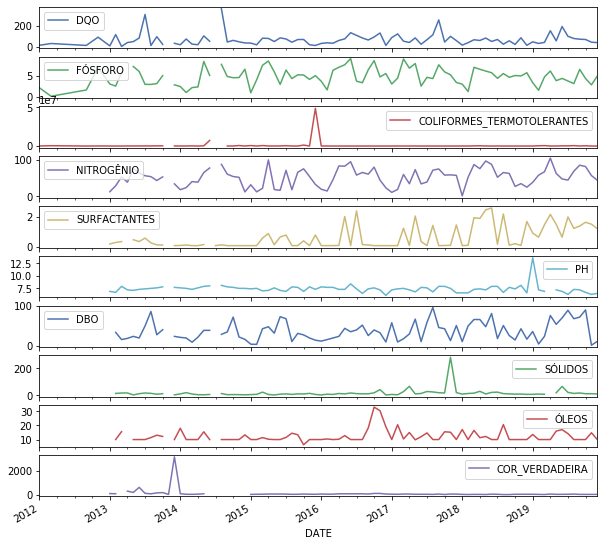

In [98]:
# df = df.set_index("DATA")
df_fixed.iloc[:, 0:10].plot(subplots=True, figsize=(10, 10));

In [154]:
# name = df_fixed.columns
year = df_fixed.index.year.astype("int")
sns.FacetGrid(df_fixed, row="")

i = 0
for column in df_fixed.columns:
    # print(column)
    figure, ax = plt.subplots(4, 2)
    sns.boxplot(x=year, y=df_fixed[column], ax=ax[i])
    i += 1
# sns.boxplot(df_fixed, x="YEAR", y="DQO")

AttributeError: 'numpy.ndarray' object has no attribute 'boxplot'

## Verificando a Distribuição dos Valores

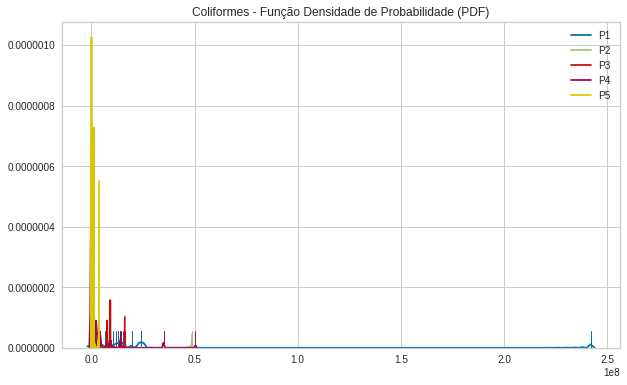

In [30]:
entity_names = df.ENTIDADE.unique().tolist()
entities = [df.loc[df['ENTIDADE'] == entity_name] for entity_name in entity_names]

for entity in entities:
    sns.distplot(entity[[name]].dropna(), hist=False, rug=True, label=str(entity['ENTIDADE'].unique()[0]))
plt.title(f"{name.capitalize()} - Função Densidade de Probabilidade (PDF)");

## Série Histórica

<Figure size 1080x576 with 0 Axes>

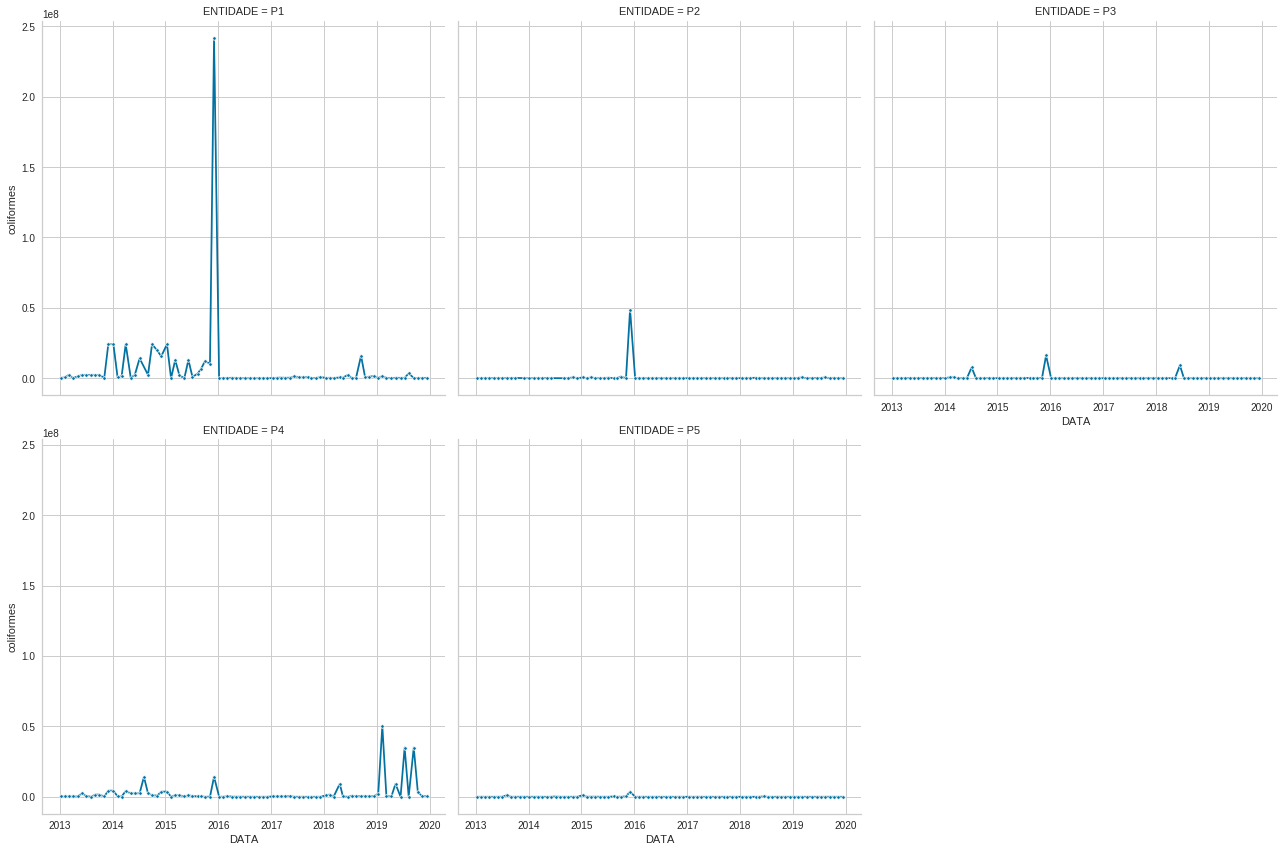

In [31]:
plt.figure(figsize=(15, 8))
g = sns.FacetGrid(data=df, col="ENTIDADE", col_wrap=3, height=6, dropna=True)
g = g.map(sns.lineplot, "DATA", name, marker=".", palette="Set2")
plt.show();
# for ax in g.axes.flat:
#     for label in ax.get_xticklabels():
#         label.set_rotation(90)

## Localizando outliers

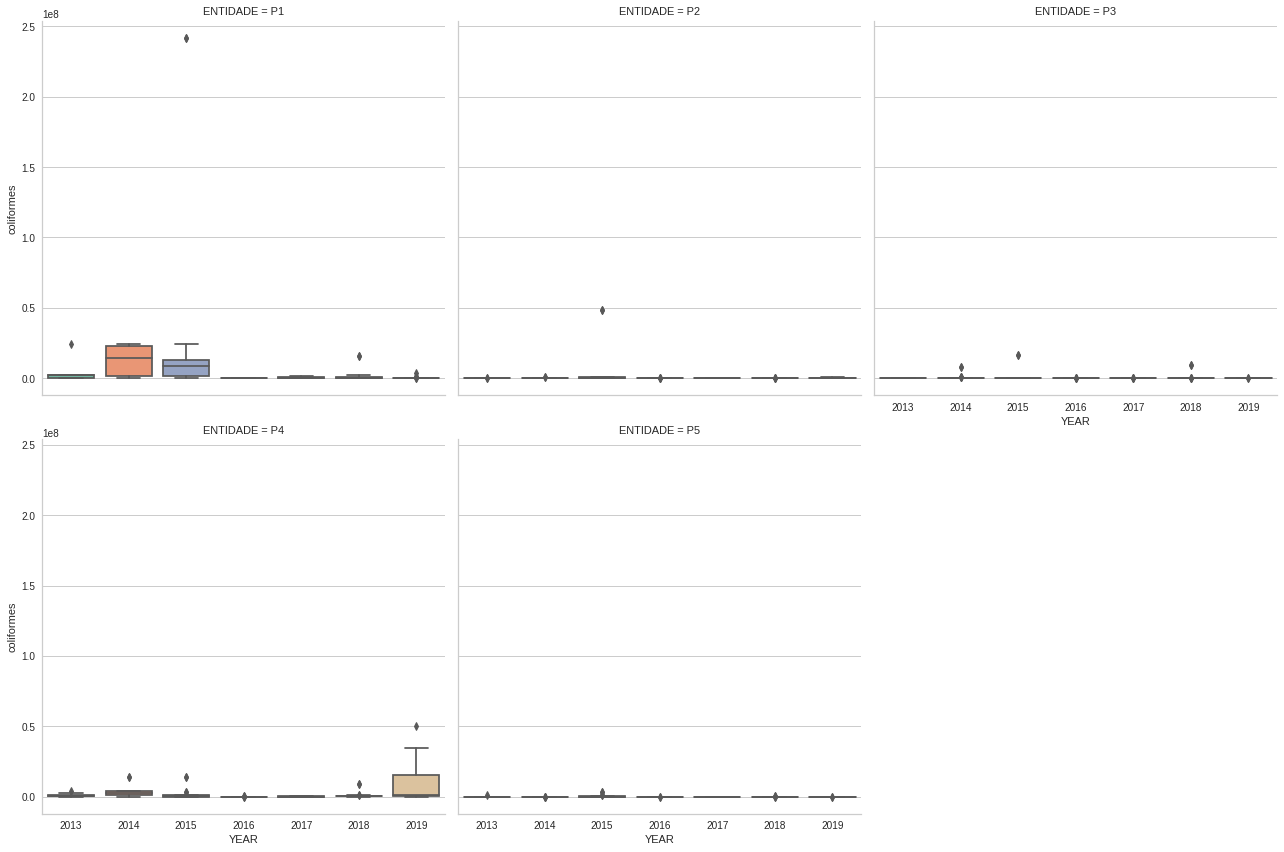

In [32]:
g = sns.FacetGrid(data=df, col="ENTIDADE", col_wrap=3, height=6, dropna=True);
g = g.map(sns.boxplot, "YEAR", name, palette="Set2")

In [14]:
df.drop(columns=["YEAR"], inplace=True)
df.to_csv(f"./Normalized/{name}.csv", encoding='utf8', index=False)
# copy2("EDA.ipynb", f"./EDA/EDA_{name}.ipynb")